## TTS module for our Pipeline

Dans ce notebook on va générer des fichiers audios à partir de textes.

On va premièrement utiliser le modèle [gTTS](https://gtts.readthedocs.io/en/latest/) qui est un modèle de TTS (Text To Speech) basé sur Google Translate.
Sur ce modèle nous allons utiliser le dataset [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) qui est un dataset de textes en anglais. Celui ci nous permettra d'évaluer la qualité de notre modèle.

Ensuite, nous utilisons le dataset des transcripts de sortie du GEC. Cette partie simulera l'utilisation de notre modèle dans la pipeline, et pourra être réutilisée directement dans la pipeline si les résultats sont considérés comme satisfaisants.


Autres modèles de TTS :
- [Tacotron2](https://huggingface.co/transformers/model_doc/tacotron2.html) (exemple avec vocodeur HiFiGAN, sur modèle pré-entrainé avec le dataset LJSpeech [ici](https://huggingface.co/speechbrain/tts-tacotron2-ljspeech))
- [FastSpeech2](https://fastspeech2.github.io/fastspeech2/)
Vocodeurs:
- [HiFiGAN](https://pytorch.org/hub/nvidia_deeplearningexamples_hifigan/)
- [MelGAN](https://paperswithcode.com/method/melgan)
- WaveGlow


Les datasets se trouvent dans un dossier `data/` et les fichiers audios générés dans un dossier `output/`.

### Import des librairies

In [49]:
import torchaudio, torch, os
import IPython.display as ipd
from torch.utils.data import Dataset, DataLoader

from gtts import gTTS
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

!pip3 install -q -U deep_phonemizer

## Définition des fonctions

In [137]:
class GEC_Dataset(Dataset):
    def __init__(self, path, text):
        
        self.sentences = []
        
        if text is not None:
            self.sentences.append(text.strip())
        else:
            self.path = path
            self.files = os.listdir(path)
            for file in self.files:
                with open(path + '\\' + file, 'r', encoding='utf-8') as file:
                    for line in file:
                        self.sentences.append(line.strip())
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        transcript = self.sentences[idx]

        return transcript, idx


def load_librispeech_dataset(path='data\\'):
    librispeech_dataset = torchaudio.datasets.LIBRISPEECH(path, url='dev-clean', download=True)
    #Shorten dataset to 500 samples
    librispeech_dataset_short = torch.utils.data.Subset(librispeech_dataset, range(1))
    librispeech_dataloader = DataLoader(librispeech_dataset_short, batch_size=1)
    
    print("Number of samples:", len(librispeech_dataset_short))
    
    sample_meta0 = librispeech_dataset.get_metadata(0)
    sample_0 = librispeech_dataset_short[0][0]
    print("""
    Audio n°0 :
    
    Path audio: {}{}
    Sample rate : {}
    Transcript : {}
    Speaker ID : {}
    Chapter ID : {}
    Utterance ID : {}
    """.format(path + "LibriSpeech", *sample_meta0))
    
    #Playing sample_O
    ipd.Audio(sample_0, rate=sample_meta0[1])
    
    return librispeech_dataloader

def process_librispeech(data, model='gtts', output_folder='output'):
    (waveform, sample_rate, transcript, ID_s, ID_c, ID_u) = data
    
    waveform = waveform.squeeze(0)
    sample_rate = sample_rate.squeeze(0)
    transcript = str(transcript[0])
    ID = "-".join((str(ID_s.item()), str(ID_c.item()), str(ID_u.item()))).replace(',','')
    
    file = f'./{output_folder}/out_{ID}.mp3'
    
    if os.path.exists(file):
        return ID, file, 1, None, None
    
    return ID, file, 0, transcript, (waveform, sample_rate)


def load_GEC_dataset(path='data\\GEC', text=None, dataset=GEC_Dataset):
    GEC_Dataset = dataset(path, text)
    GEC_Dataloader = DataLoader(GEC_Dataset, batch_size=1)
    
    print("Number of samples:", len(GEC_Dataset))
    
    sample_meta0 = GEC_Dataloader.dataset[0]
    print("""
    Transcript n°0 :
    
    Transcript : {}
    Transcript ID : {}
    """.format(*sample_meta0))
    
    return GEC_Dataloader


def process_GEC(data, model='gtts', output_folder='output'):
    (transcript, ID) = data
    ID = ID.item()
    file = f'./{output_folder}/out_{ID}.mp3'
    
    return ID, file, 0, transcript, None

def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

In [222]:
def TTS(text:str=None, model='gtts', output_folder='output', dataset='GEC'):
    pipeline = "/pipeline/" if text is not None else "/"
    output_folder = output_folder + pipeline + model + '_' + dataset
    os.makedirs(output_folder, exist_ok=True)
    # TQDM loader
    try:
        function = "load_" + dataset + "_dataset"
        dataloader = eval(function)(text=text)
        dataloader_tqdm = tqdm(dataloader, total=len(dataloader))
    
        process_function = "process_" + dataset
        
    except NameError:
        raise ValueError(f'Unknown dataset {dataset}')
    
    bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
    processor = bundle.get_text_processor()
    tacotron2 = bundle.get_tacotron2().to("cuda")
    file_out=''
    print(f'Generating audio files with {model} model in {output_folder} folder')
    
    for i, data in enumerate(dataloader_tqdm):
        (ID, file_out, out, transcript, evalua) = eval(process_function)(data, model=model, output_folder=output_folder)
        file_out = file_out if type(file_out) == str else file_out[0]
        transcript = str(transcript)
        if out == 1:
            dataloader_tqdm.set_postfix({'status': 'Skipped', 'ID': ID})
            continue

        try:
            #Passage du transcript dans le modèle
            if model == 'gtts':
                tts = gTTS(transcript, lang='en')#, tld='co.in')
                tts.save(file_out)
            elif model == 'tacotron2':
                with torch.inference_mode():
                    processed, lengths = processor(transcript)
                    processed = processed.to("cuda")
                    lengths = lengths.to("cuda")
                    spec, spec_l, _ = tacotron2.infer(processed, lengths)

                plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto", cmap="viridis")
                plt.show()

            else:
                raise ValueError(f'Unknown model {model}')
            
            dataloader_tqdm.set_postfix()
        

        except Exception as e:
            dataloader_tqdm.set_postfix({'status': 'Error', 'ID': ID})
            raise e
            
        
        if evalua != None:
            waveform, sample_rate = evalua
            transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, win_length=1024, hop_length=256)
            mel_specgram = transform(waveform)
            mag_spect = torch.stft(waveform, 1024, window=torch.hamming_window(1024), return_complex=True, hop_length=256)
            mag_spect = torch.sqrt(torch.abs(mag_spect.permute(1,2,0)))
            mel_specgram = torch.sqrt(torch.abs(mel_specgram))
            plt.imshow(mel_specgram[0], origin="lower", aspect="auto", cmap="viridis")
            from sklearn.metrics.pairwise import cosine_similarity
            import numpy as np

                # Flatten the spectrograms
            spec1 = mel_specgram[0].cpu().detach()
            spec2 = spec.squeeze().cpu().detach()
            
            
            shape1 = spec1.shape
            shape2 = spec2.shape
            
            # Find the size differences along both axes
            size_diff_rows = shape2[0] - shape1[0]
            size_diff_cols = shape2[1] - shape1[1]
            
            if size_diff_rows > 0:      
                padded_spec1 = np.pad(spec1, ((0, size_diff_rows), (0, 0)), mode='constant')
            else:
                padded_spec1 = spec1
            
            if size_diff_cols > 0:
                padded_spec2 = np.pad(spec2, ((0, 0), (0, size_diff_cols)), mode='constant')
            else:
                padded_spec2 = spec2


            flat_spec1 = padded_spec1.flatten()
            flat_spec2 = padded_spec2.flatten()
            min_size = min(len(flat_spec1), len(flat_spec2))
            flat_spec1 = flat_spec1[:min_size]
            flat_spec2 = flat_spec2[:min_size]
            # Compute cosine similarity
            similarity_measure = cosine_similarity([flat_spec1], [flat_spec2])[0, 0]
            print(similarity_measure)
            
            mse = np.mean((padded_spec1 - padded_spec2)**2)
            similarity_measure = 1 / (1 + mse) 
            print(similarity_measure)
            
            from fastdtw import fastdtw

            # Assuming spec1 and spec2 are the normalized spectrograms
            distance, path = fastdtw(padded_spec1, padded_spec2)
            similarity_measure = 1 / (1 + distance)  # Invert to get a similarity measure
            print(similarity_measure)
    
    
    return torchaudio.load(file_out) if file_out != '' else None

___
## TTS model gtts
### Dataset Librispeech
Le même qu'on a utilisé pour générer les fichiers audios pour le dataset

Number of samples: 1

    Audio n°0 :
    
    Path audio: data\LibriSpeechdev-clean\1272\128104\1272-128104-0000.flac
    Sample rate : 16000
    Transcript : MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
    Speaker ID : 1272
    Chapter ID : 128104
    Utterance ID : 0
    


  0%|          | 0/1 [00:00<?, ?it/s]

D:\Projets\env\3.10\utils_env\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Generating audio files with tacotron2 model in output/tacotron2_librispeech folder


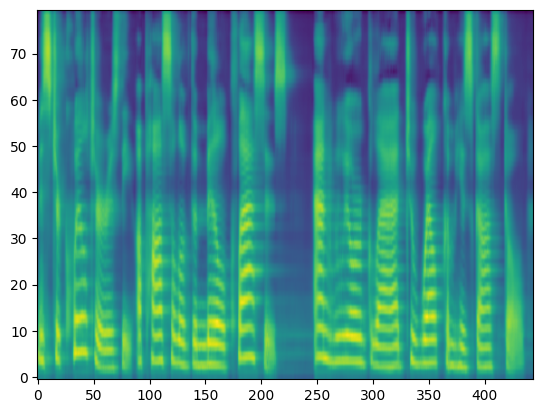

-0.27199686


ValueError: operands could not be broadcast together with shapes (128,366) (80,522) 

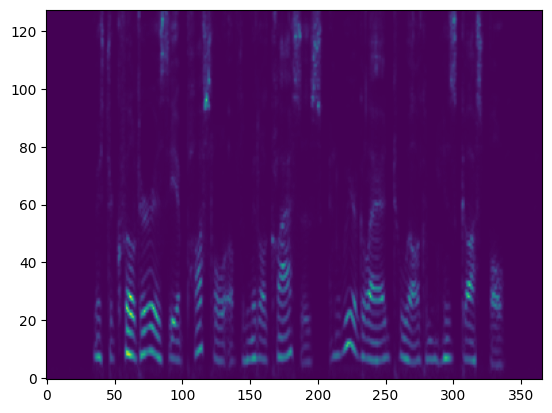

In [223]:
# TTS(model='tacotron2', output_folder='output', dataset='librispeech')

#### Dataset GEC (pour pipeline)

In [11]:
# TTS(model="gtts", output_folder="output", dataset="GEC")

Number of samples: 17

    Transcript n°0 :
    
    Transcript : She doesn't like to eat vegetables.
    Transcript ID : 0
    


  0%|          | 0/17 [00:00<?, ?it/s]

Generating audio files with gtts model in output/gtts_GEC folder
